In [150]:
import geopandas
import pandas as pd
import numpy as np

from shapely.geometry import Point, box
from shapely.strtree import STRtree
from shapely.ops import nearest_points

from litecoder.models import Locality

In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('seaborn-muted')

In [178]:
rows = []
for loc in Locality.query.filter(Locality.country_iso=='US'):
    rows.append((loc.name, loc.us_state_abbr, loc.longitude, loc.latitude, loc.population))
    
df = pd.DataFrame(rows, columns=('name', 'state', 'longitude', 'latitude', 'population'))

In [179]:
df['point'] = list(zip(df.longitude, df.latitude))
df['point'] = df['point'].apply(Point)

In [180]:
gdf = geopandas.GeoDataFrame(df, geometry='point')

In [181]:
gdf.head(10)

,name,state,longitude,latitude,population,point
0,Valley Head,AL,-85.621354,34.557517,558.0,POINT (-85.621354 34.557517)
1,Sylvania,AL,-85.804804,34.562109,1837.0,POINT (-85.804804 34.562109)
2,Shiloh,AL,-85.877994,34.463763,274.0,POINT (-85.877994 34.463763)
3,Rainsville,AL,-85.843520,34.493782,4948.0,POINT (-85.84352 34.493782)
4,Powell,AL,-85.897879,34.532534,NaN,POINT (-85.897879 34.532534)
5,Pine Ridge,AL,-85.780673,34.448890,282.0,POINT (-85.78067299999999 34.44889)
6,Mentone,AL,-85.584222,34.566291,360.0,POINT (-85.584222 34.566291)
7,Lakeview,AL,-85.975703,34.391629,143.0,POINT (-85.975703 34.391629)
8,Tuscumbia,AL,-87.703381,34.721209,8423.0,POINT (-87.70338099999999 34.721209)
9,Geraldine,AL,-86.003706,34.357721,896.0,POINT (-86.00370599999999 34.357721)


In [184]:
gdf[gdf.state=='AL']

,name,state,longitude,latitude,population,point
0,Valley Head,AL,-85.621354,34.557517,558.0,POINT (-85.621354 34.557517)
1,Sylvania,AL,-85.804804,34.562109,1837.0,POINT (-85.804804 34.562109)
2,Shiloh,AL,-85.877994,34.463763,274.0,POINT (-85.877994 34.463763)
3,Rainsville,AL,-85.843520,34.493782,4948.0,POINT (-85.84352 34.493782)
4,Powell,AL,-85.897879,34.532534,NaN,POINT (-85.897879 34.532534)
5,Pine Ridge,AL,-85.780673,34.448890,282.0,POINT (-85.78067299999999 34.44889)
6,Mentone,AL,-85.584222,34.566291,360.0,POINT (-85.584222 34.566291)
7,Lakeview,AL,-85.975703,34.391629,143.0,POINT (-85.975703 34.391629)
8,Tuscumbia,AL,-87.703381,34.721209,8423.0,POINT (-87.70338099999999 34.721209)
9,Geraldine,AL,-86.003706,34.357721,896.0,POINT (-86.00370599999999 34.357721)


In [183]:
sum(gdf.population.isna())

31352

In [172]:
gdf.population = gdf.population.fillna(gdf.population.median())

1215


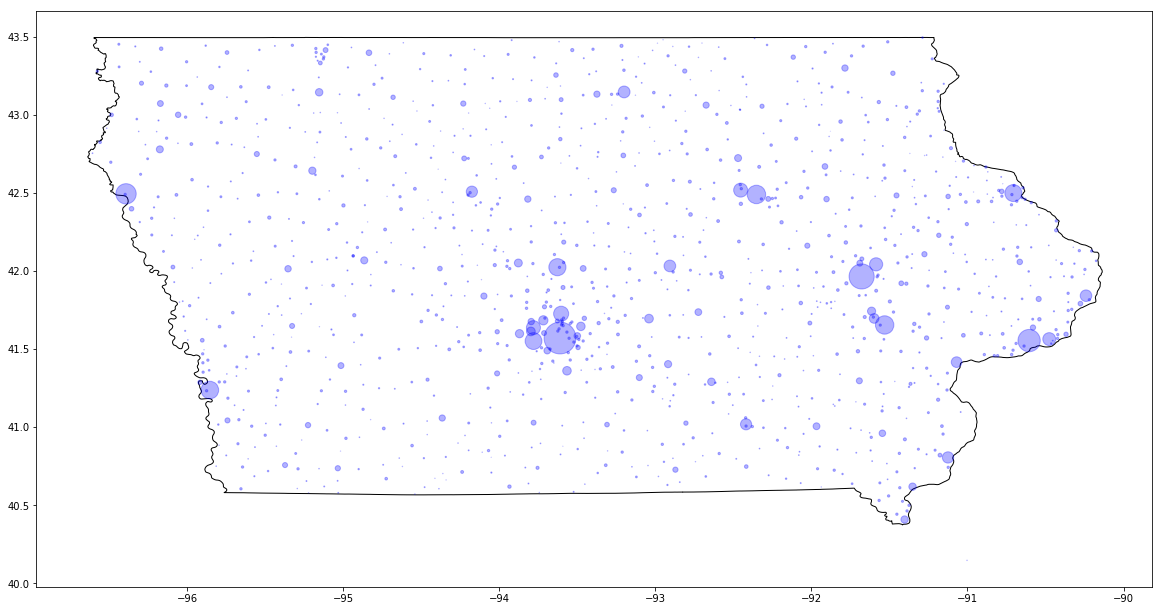

In [177]:
state = 'IA'

states = geopandas.read_file('../data/cb_2017_us_state_5m/cb_2017_us_state_5m.shp')

ax = states[states.STUSPS==state].plot(color='white', edgecolor='black', figsize=(20,20))

sdf = gdf[gdf.state==state]
print(len(sdf))

sdf.plot(ax=ax, color='blue', markersize=sdf['population'] / 200, alpha=0.3)
plt.show()

In [170]:
gdf.population.fillna(gdf.population.median())

0          558.0
1         1837.0
2          274.0
3         4948.0
4         1145.0
5          282.0
6          360.0
7          143.0
8         8423.0
9          896.0
10         723.0
11        2344.0
12         488.0
13        9039.0
14        1018.0
15       13146.0
16       14012.0
17        1011.0
18        1862.0
19         729.0
20        1048.0
21        2538.0
22        3485.0
23         170.0
24         208.0
25         192.0
26          53.0
27         346.0
28        4020.0
29       20756.0
          ...   
54697     1145.0
54698     1145.0
54699     1145.0
54700     1145.0
54701     1145.0
54702     1145.0
54703     1145.0
54704     1145.0
54705     1145.0
54706     1145.0
54707     1145.0
54708     1145.0
54709     1145.0
54710     1145.0
54711     1145.0
54712     1145.0
54713     1145.0
54714     1145.0
54715     1145.0
54716     1145.0
54717     1145.0
54718     1145.0
54719     1145.0
54720     1145.0
54721     1145.0
54722     1145.0
54723     1145.0
54724     1145